In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jraph
import optax
from flax import nnx
import orbax.checkpoint as ocp

import scipy.spatial
from functools import partial
import jax.tree_util as tree

from jaxpm.painting import cic_paint, cic_read
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm.nn import MLP, ResNet3D, ResNetBlock3D, GraphConvolution, GNN, GATGNN
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3

## Loading the snapshots

In [4]:
# i_snapshots=range(1, 33+4, 4)
i_snapshots=[-1]

In [20]:
# SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1"

train_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=i_snapshots,
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 1/1 [00:10<00:00, 10.96s/it]


In [21]:
# vmap over the snapshots
# vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,None))
# vcic_read = jax.vmap(cic_read, in_axes=(0,0))

vcic_paint = cic_paint
vcic_read = cic_read

def preprocess(snapshot_dict):
    cosmo = snapshot_dict["cosmo"]
    scales = snapshot_dict["scales"]
    gas_poss = snapshot_dict["gas_poss"]
    gas_Ps = snapshot_dict["gas_Ps"]
    
    # rho (exactly like in PM)
    rho_dm = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["dm_poss"], None)
    rho_gas = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["gas_poss"], cosmo.Omega_b / cosmo.Omega_c)
    rho = rho_dm + rho_gas
    gas_rho = vcic_read(rho, gas_poss)
    
    # fscalar
    kvec = fftk(mesh_shape)
    delta_k = jax.vmap(jnp.fft.rfftn, in_axes=0)(rho)
    fscalar = jax.vmap(jnp.fft.irfftn, in_axes=0)(delta_k * invnabla_kernel(kvec))
    gas_fscalar = vcic_read(fscalar, gas_poss)

    return scales, gas_poss, gas_rho, gas_fscalar, gas_Ps

scales, gas_pos, gas_rho, gas_fscalar, gas_P = preprocess(train_dict)

# graph construction

In [22]:
def scipy_get_k_nearest_neighbor_idx(points, k, distance_upper_bound=np.inf, boxsize=None, workers=-1, leafsize=10):
    kd_tree = scipy.spatial.cKDTree(data=points, boxsize=boxsize, leafsize=leafsize)
    distances, idx = kd_tree.query(x=points, k=int(k), workers=workers, distance_upper_bound=distance_upper_bound)
    return distances.astype(points.dtype), idx.astype(np.int32)


@partial(jax.jit, static_argnames=["k", "distance_upper_bound", "boxsize", "workers", "leafsize"])
def jax_callback_get_k_nearest_neighbor_idx(
    points, k, distance_upper_bound=np.inf, boxsize=None, workers=-1, leafsize=10
):
    shape = (jnp.shape(points)[0], k)
    distance_type = jax.ShapeDtypeStruct(shape, points.dtype)
    idx_type = jax.ShapeDtypeStruct(shape, jnp.int32)
    return jax.pure_callback(
        scipy_get_k_nearest_neighbor_idx,
        (distance_type, idx_type),
        points,
        k,
        distance_upper_bound,
        boxsize,
        workers,
        leafsize,
    )


knn_scipy = jax_callback_get_k_nearest_neighbor_idx

In [23]:
k = 24
n_node = gas_pos.shape[0]
n_edge = k * n_node

k_dist, k_idx = knn_scipy(gas_pos, k, boxsize=64)

node_features = jnp.stack([jnp.log10(gas_rho), jnp.arcsinh(gas_fscalar/100)], axis=-1)
edge_features = k_dist.reshape(-1, 1)

# senders = k_idx
# receivers = jnp.arange(n_node, dtype=jnp.int32)
senders = k_idx.reshape(-1)
receivers = jnp.repeat(jnp.arange(n_node, dtype=jnp.int32), k)

graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=edge_features,
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=None,
)

print("node_features.shape", node_features.shape)
print("edge_features.shape", edge_features.shape)
print("senders.shape", senders.shape)
print("receivers.shape", receivers.shape)

node_features.shape (262144, 2)
edge_features.shape (6291456, 1)
senders.shape (6291456,)
receivers.shape (6291456,)


# model

In [9]:
# X = graph
# Y = jnp.expand_dims(jnp.log10(gas_P), -1)

In [10]:
# model = GNN(
#     d_in=2, 
#     d_out=1, 
#     d_hidden=64,
#     n_hidden=4,
#     rngs=nnx.Rngs(0),
#     normalize=True,
# )

In [11]:
# X = graph.nodes
# Y = jnp.expand_dims(jnp.log10(gas_P), -1)

# model = MLP(X.shape[-1], Y.shape[-1], 64, 4, nnx.Rngs(0))

In [12]:
X = graph
Y = jnp.expand_dims(jnp.log10(gas_P), -1)

model = GATGNN(
    d_node=X.nodes.shape[-1],
    d_edge=X.edges.shape[-1],
    d_query=16,
    n_hidden=4,
    d_out=Y.shape[-1],
    rngs=nnx.Rngs(0),
)

In [24]:
X = graph
Y = jnp.expand_dims(jnp.log10(gas_P), -1)

# particle-level GNN (predict P)

In [14]:
def get_train_step(model, optimizer):

    @jax.jit
    def train_step(params, opt_state, batch):
        x, y = batch
    
        def loss_fn(params):
            model = nnx.merge(graphdef, params)
            y_pred = model(x)
            loss = jnp.mean((y - y_pred.nodes) ** 2)
            # loss = jnp.mean((y - y_pred) ** 2)
            return loss
        
        loss, grads = jax.value_and_grad(loss_fn)(params)
    
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    
        return params, opt_state, loss

    return train_step

In [15]:
total_steps = 2_000
batch_size = 1_024
# learning_rate = 1e-3
learning_rate = optax.cosine_decay_schedule(
    init_value=1e-3, 
    decay_steps=total_steps, 
    alpha=0.1
)
clip_norm = 1

optimizer = optax.chain(
    optax.clip_by_global_norm(clip_norm),
    optax.adam(learning_rate)
)
losses = []

graphdef, params = nnx.split(model)
opt_state = optimizer.init(params)

train_step = get_train_step(model, optimizer)

### training

MSE: 0.1147: 100%|██████████| 2000/2000 [02:44<00:00, 12.13it/s]


[None]

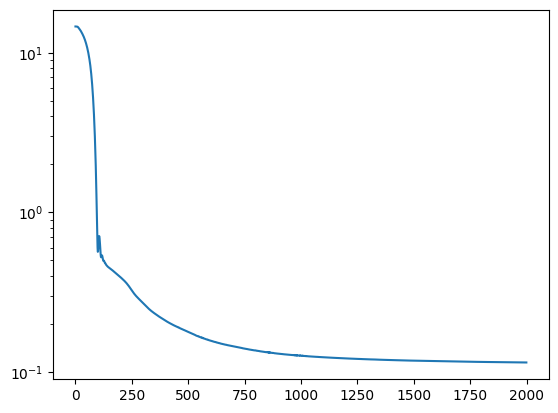

In [16]:
for i in (pbar := tqdm.tqdm(range(total_steps))):    
    batch = (X, Y)
    
    params, opt_state, loss = train_step(params, opt_state, batch)
    losses.append(loss)

    pbar.set_description(f"MSE: {loss:.4f}")

model = nnx.merge(graphdef, params)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set(yscale="log")

### testing

In [17]:
def normalized_paint(positions, weights):
    rho_pos = cic_paint(jnp.zeros([mesh_per_dim] * 3), positions)
    pos_rho = cic_read(rho_pos, positions)

    return cic_paint(jnp.zeros(mesh_shape), positions, weights/pos_rho)

def plot_field(field, ax, vlims=None):
    log_sum = jnp.log10(field.sum(axis=0))

    if vlims is None:
        vmin, vmax = log_sum.min(), log_sum.max()
        vlims = (vmin, vmax)
    else:
        vmin, vmax = vlims
    
    return ax.imshow(log_sum, cmap="magma", vmin=vmin, vmax=vmax), vlims, log_sum

In [25]:
P_camels = normalized_paint(gas_pos, gas_P)
P_particle = normalized_paint(gas_pos, 10**jnp.squeeze(model(X).nodes))
# P_particle = normalized_paint(gas_pos, 10**jnp.squeeze(model(X)))

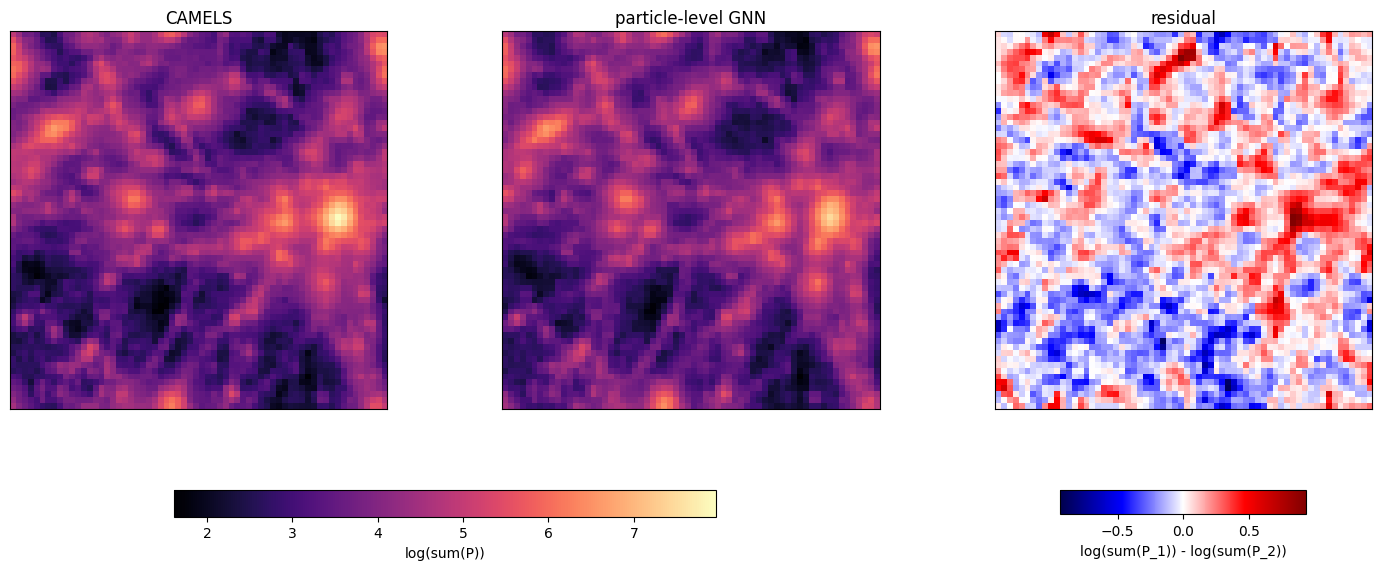

In [26]:
fig, ax = plt.subplots(figsize=(3*6, 6+1), ncols=3)

im, vlims, P_camels_log_sum = plot_field(P_camels, ax[0])
ax[0].set(title="CAMELS")

im, _, P_particle_log_sum = plot_field(P_particle, ax[1], vlims=vlims)
ax[1].set(title="particle-level GNN")

fig.colorbar(im, ax=ax[:2], label="log(sum(P))", orientation="horizontal", shrink=0.6, aspect=20)

residual = P_camels_log_sum - P_particle_log_sum
lim = np.max(np.abs(residual))

im = ax[2].imshow(residual, cmap="seismic", vmin=-lim, vmax=lim)
ax[2].set(title="residual")
fig.colorbar(im, ax=ax[2], label="log(sum(P_1)) - log(sum(P_2))", orientation="horizontal", shrink=0.6, aspect=10)

for i in range(len(ax)):
    ax[i].set_yticks([])
    ax[i].set_xticks([])